# Classification
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository. The goal of this part is to build a machine learning model to predict which playlist the track belongs to. The attempt is stricktly experimental because the assignment is most of the time stricktly subjective, it is susceptible to personal biases and tiny musial nuances. 

There are 29 playlists and XXXX unique songs in the dataset. Some of the songs are assigned to more than one playlist which makes things even harder. Nevertheless, let's give it a try.

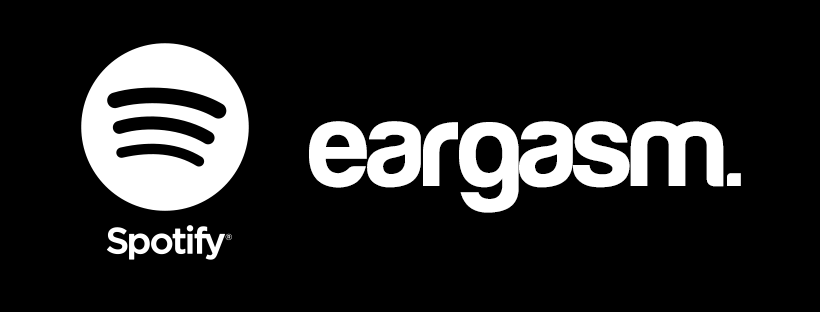

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

eargasm_Classification.ipynb   eargasm_DataRetrieval.ipynb  README.md
eargasm_DataExploration.ipynb  files


## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars
- `timeit` - Measure execution time of small code snippets

In [4]:
from tqdm.notebook import tqdm
import timeit

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [6]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go

## Machine learning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# estimators
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# from sklearn.compose import make_column_transformer
# from sklearn.pipeline import make_pipeline



# Feature engineering

# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [8]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


## Select features
Not all features will be useful for model-building therefore I'll drop them. Some features might seem not correct to get rid of so let me explain:
- `track_artist` - due to large number of artists the feature would slow the algorithm down; also, knowing the dataset, it doesn't seem to be a good clue for an algorithm
- `track_populariy` - there's a lot of zeroes in this feature; additionally the mean of the feature is roughly the same regardless of the playlist
- `track_genre` - similarily to `track_artist` there's too many different genres, which would slow down the process; additionally there's a lot of similar tags and it's just doesn't seem to be helpful anyhow
- `mode` - no correlation with the playlists
- `key` - no correlation with the playlists
- `time_signature` - no correlation with the playlists

In [9]:
features_to_keep = [
                    'track_playlist',
                    'track_duration',
                    'track_popularity',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'tempo',
                    ]
df_encoded = final_df[features_to_keep]

df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)
df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)

df_encoded.head()

,track_playlist,track_duration,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo
0,eargasm | breathe easy,4.187767,42,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,86.502
1,eargasm | breathe easy,4.237217,51,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,98.003
2,eargasm | breathe easy,3.461650,0,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,85.036
3,eargasm | breathe easy,3.544000,0,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,125.088
4,eargasm | breathe easy,4.580000,47,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,170.556


## Features encoding

In [10]:
# def cut_into_categories(feature_name, number_of_categories):

#   df_encoded[feature_name] = final_df[feature_name]  
#   df_encoded[feature_name] = pd.cut(df_encoded[feature_name], number_of_categories)

#   ranges = df_encoded[feature_name].unique()
#   ranges.sort_values(inplace=True)

#   for n, value in enumerate(ranges):
#     df_encoded.loc[df_encoded[feature_name] == value, feature_name+'_en'] = n+1

#   df_encoded.drop(columns=[feature_name], inplace=True)
#   df_encoded.rename(columns = {feature_name+'_en': feature_name}, inplace = True)

#   return df_encoded

In [11]:
# def fill_nans(feature_name):
#   df_encoded[feature_name].fillna(int(df_encoded[feature_name].mean()), inplace=True)
#   return df_encoded

In [12]:
# df_encoded['track_duration'] = final_df['track_duration'] # reset value
# df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

# cut_into_categories('track_duration', 10)
# cut_into_categories('track_popularity', 10)
# cut_into_categories('acousticness', 10)
# cut_into_categories('danceability', 10)
# cut_into_categories('energy', 10)
# cut_into_categories('instrumentalness', 10)
# cut_into_categories('liveness', 10)
# cut_into_categories('speechiness', 10)
# cut_into_categories('valence', 10)
# cut_into_categories('tempo', 15)

# df_encoded['track_genre'].fillna('unknown', inplace=True)
# df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)


# fill_nans('key')
# fill_nans('mode')
# fill_nans('time_signature')

# df_encoded = df_encoded.dropna()
# df_encoded.head()

# Multiclass classification

## Train/test split

In [13]:
X = df_encoded[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_encoded['track_playlist']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Model selection
Let's use a list of commonly used classifiers and run them with default setting to see how well they perform in terms of accuracy and runtime. After iterating through them, I'll choose three or four best performing ones and try to evaluate them further in order to find a right one.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis


list_of_classifiers = [
                       LogisticRegression(),
                       KNeighborsClassifier(),
                       svm.SVC(),
                       DecisionTreeClassifier(),
                       MLPClassifier(),
                       RandomForestClassifier(),
                       AdaBoostClassifier(),
                       GaussianNB(),
                       QuadraticDiscriminantAnalysis(),
                       LinearDiscriminantAnalysis()
                      ]

In [16]:
classifiers = pd.DataFrame()

for classifier in tqdm(list_of_classifiers):
  
  clf = classifier

  start = timeit.default_timer()
  clf.fit(X_train, y_train)
  stop = timeit.default_timer()

  name = str(classifier).split('(')[0]
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)
  mean_score = (train_score+test_score)/2
  runtime = stop-start

  classifiers = classifiers.append(
      {'classifier': name,
       'score_train': train_score,
       'score_test': test_score,
       'score_mean': mean_score,
       'runtime': runtime
      },
      ignore_index = True)

classifiers.sort_values(by='score_mean', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,classifier,runtime,score_mean,score_test,score_train
5,RandomForestClassifier,1.363084,0.423873,0.123620,0.724125
3,DecisionTreeClassifier,0.050458,0.395727,0.067329,0.724125
1,KNeighborsClassifier,0.013278,0.213754,0.105960,0.321547
9,LinearDiscriminantAnalysis,0.011990,0.199527,0.189845,0.209208
8,QuadraticDiscriminantAnalysis,0.007808,0.195116,0.173289,0.216943
7,GaussianNB,0.010985,0.183698,0.173289,0.194107
4,MLPClassifier,2.372565,0.178358,0.172185,0.184530
0,LogisticRegression,0.902067,0.169513,0.181015,0.158011
6,AdaBoostClassifier,0.617871,0.129764,0.128035,0.131492
2,SVC,0.622015,0.106200,0.111479,0.100921


In [17]:
def model_evaluation(estimator, parameters):
  clf = estimator
  parameters = parameters

  search = GridSearchCV(clf, parameters)
  search.fit(X_train, y_train)

  b_score = search.best_score_
  b_parameters = search.best_params_
  b_estimator = search.best_estimator_
  score_train = b_estimator.score(X_train, y_train)
  score_test = b_estimator.score(X_test, y_test)
  score_mean = (score_train+score_test)/2

  evaluation_results = dict(runtime=runtime,
                            b_score=b_score,
                            b_parameters=b_parameters,
                            b_estimator=b_estimator,
                            score_test=train_score,
                            score_train=score_train,
                            score_mean=score_mean
                           )

  return evaluation_results

### Random Forest Classifier

`RandomForestClassifier()` had the best `mean_score` of all estimators but looks like it's overfitting the data. It also ran significantly longer than most of the others but let's evalue it further. 

https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [18]:
start = timeit.default_timer()

parameters = {
              'n_estimators': [10, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [3, 4, 5, 6],
              'max_features': [2, 3, 4]
             }

evaluation_results = model_evaluation(RandomForestClassifier(n_jobs=-1), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 230.48472336900159 seconds.


In [19]:
evaluation_results

{'b_estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=5, max_features=2,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                        oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 'b_parameters': {'criterion': 'gini',
  'max_depth': 5,
  'max_features': 2,
  'n_estimators': 50},
 'b_score': 0.19152854511970535,
 'runtime': 0.011990363993390929,
 'score_mean': 0.24611003378337176,
 'score_test': 0.20920810313075505,
 'score_train': 0.2847145488029466}

In [20]:
rfc = evaluation_results['b_estimator']

### Decision Tree Classifier

`DecisionTreeClassifier()` received `mean_score` similar to `RandomForestClassifier()` and overfits similarily. However, the algorithm seems to be a lot faster, so let's give it a try.

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [21]:
start = timeit.default_timer()

parameters = {
              'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'max_features': ['auto', 'sqrt', 'log2', None]
             }

evaluation_results = model_evaluation(DecisionTreeClassifier(), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 12.380497933001607 seconds.


In [22]:
evaluation_results

{'b_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=4, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'b_parameters': {'criterion': 'gini',
  'max_depth': 4,
  'max_features': None,
  'splitter': 'best'},
 'b_score': 0.15248618784530388,
 'runtime': 0.011990363993390929,
 'score_mean': 0.16879001866012952,
 'score_test': 0.20920810313075505,
 'score_train': 0.18084714548802946}

In [23]:
dtc = evaluation_results['b_estimator']

### K-Neighbors Classifier
https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

In [24]:
start = timeit.default_timer()

parameters = {
              'n_neighbors': range(1, 10),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(10, 100, 10),
              'p': [1, 2]
             }

evaluation_results = model_evaluation(KNeighborsClassifier(), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 165.4453947630027 seconds.


In [25]:
evaluation_results

{'b_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=40, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                      weights='uniform'),
 'b_parameters': {'algorithm': 'auto',
  'leaf_size': 40,
  'n_neighbors': 9,
  'p': 1,
  'weights': 'uniform'},
 'b_score': 0.12302025782688766,
 'runtime': 0.011990363993390929,
 'score_mean': 0.2026941324259388,
 'score_test': 0.20920810313075505,
 'score_train': 0.281767955801105}

In [26]:
knn = evaluation_results['b_estimator']

### Linear Discriminant Analysis

In [27]:
start = timeit.default_timer()

parameters = {
              'solver': ['svd','lsqr', 'eigen'],
              'shrinkage': ['auto', None]
             }

evaluation_results = model_evaluation(LinearDiscriminantAnalysis(), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NotImplementedError: shrinkage not supported


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NotImplementedError: shrinkage not supported


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NotImplementedError: shrinkage not supported


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Not

Runtime: 0.8371678339972277 seconds.


In [28]:
evaluation_results

{'b_estimator': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                            solver='svd', store_covariance=False, tol=0.0001),
 'b_parameters': {'shrinkage': None, 'solver': 'svd'},
 'b_score': 0.19521178637200737,
 'runtime': 0.011990363993390929,
 'score_mean': 0.1995267888722208,
 'score_test': 0.20920810313075505,
 'score_train': 0.20920810313075505}

## Model selection & cross-validation

In [46]:
clf = rfc
lda.score(X_train, y_train)

0.20920810313075505

In [42]:

scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.19 (+/- 0.03)


### Prediction test

In [50]:
def probabilities(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(n=3)
  
  index_number = X_test.index[number]
  prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']
  
  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
  
  return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth: {}'.format(prediction, df, truth))

random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

Prediction: 
 ('eargasm | curvatronik', 'https://open.spotify.com/track/5p6So4cj6s5JqWcCgtyJ5g')

 Probabilities: 
                       class  probability
2     eargasm | curvatronik     0.113458
23  eargasm | space odyssey     0.074825
18       eargasm | polymers     0.072964

 Truth: 3543    eargasm | swimming pool sunset
Name: track_playlist, dtype: object


## Support Vector Classifier

In [ ]:
# start = timeit.default_timer()

# parameters = {
#               'C': [1, 5],
#               'degree': [1, 2, 3, 4, 5],
#               'decision_function_shape': ['ovo']
#              }

# evaluation_results = model_evaluation(svm.SVC(probability=True), parameters)

# stop = timeit.default_timer()
# print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
 evaluation_results

In [ ]:
fghdfgh cghjdg

### Basic model

In [ ]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)


In [ ]:
print('Train set score: {} \n\nTest set score: {}'.format(clf.score(X_train, y_train),
                                                          clf.score(X_test, y_test)))

## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Hyper parameter tuning

#### Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

start = timeit.default_timer()

svc = svm.SVC()
distributions = dict(
    C=range(1,10),
    kernel=['linear', 'poly', 'rbf', 'sigmoid'],
    degree=range(0,10),
    gamma=['scale', 'auto'],
    decision_function_shape=['ovo', 'ovr']
                    )
clf = RandomizedSearchCV(svc, distributions)
search = clf.fit(X_test, y_test)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
search.best_params_

In [ ]:
search.best_estimator_.score(X_train, y_train)

In [ ]:
search.best_estimator_.score(X_test, y_test)

#### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

start = timeit.default_timer()

parameters = {'C':range(1,6),
              'kernel': ['linear', 'rbf', 'poly'],
              'degree': range(1,6),
              'decision_function_shape': ['ovo', 'ovr']
             }
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
search = clf.fit(X_train, y_train)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
search.best_params_

In [ ]:
search.best_estimator_.score(X_train, y_train)

In [ ]:
search.best_estimator_.score(X_test, y_test)

### Tuned model

In [ ]:
clf = svm.SVC(probability=True,
              C=3,
              decision_function_shape='ovo',
              degree=1,
              kernel='poly')
clf.fit(X_train, y_train)
print('Train set score: {} \n\nTest set score: {}'.format(clf.score(X_train, y_train), clf.score(X_test, y_test)))

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
#     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
#     verbose=False)

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# y_predict = clf.predict(X_test)
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, X_test, y_test, ax=ax)
plt.xticks(rotation=90)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

In [ ]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, clf.predict(X_test))

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit_transform(X_test)


df = pd.DataFrame(y_test)
pca_df = pd.DataFrame(pca.fit_transform(X_test))
pca_df.set_index(df.index, inplace=True)

df = df.merge(pca_df, left_index=True, right_index=True)
df = df.rename(columns={0: 'pca0', 1: 'pca1', 2: 'pca2'})
df.head()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df,
                    x='pca0',
                    y='pca1',
                    z='pca2',
                    color='track_playlist')
fig.show()

In [ ]:
stop stop

# Shit

In [ ]:
# SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
#     decision_function_shape='ovo', degree=1, gamma='scale', kernel='linear',
#     max_iter=-1, probability=False, random_state=None, shrinking=True,
#     tol=0.001, verbose=False)

0.2165
0.1898

In [ ]:
clf = svm.SVC(
              probability=True,
              C=3,
              decision_function_shape='ovo',
              degree=1,
              gamma='scale',
              kernel='linear'
             )
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(clf, 
#                                                         X, 
#                                                         y,
#                                                         # Number of folds in cross-validation
#                                                         cv=5,
#                                                         # Evaluation metric
#                                                         scoring='accuracy',
#                                                         # Use all computer cores
#                                                         n_jobs=-1, 
#                                                         # 50 different sizes of the training set
#                                                         train_sizes=np.linspace(0.01, 1.0, 5))

In [ ]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
def probabilities(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(n=3)
  
  index_number = X_test.index[number]
  prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']
  
  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
  
  return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth: {}'.format(prediction, df, truth))

random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

In [ ]:
random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

## EVALUATION & MULTILABEL
- https://medium.com/@hfdtsinghua/calculate-mean-average-precision-map-for-multi-label-classification-b082679d31be
- https://www.kaggle.com/vikashrajluhaniwal/multi-label-classification-for-tag-predictions
- https://www.kaggle.com/roccoli/multi-label-classification-with-sklearn
- https://towardsdatascience.com/a-brief-introduction-to-support-vector-machine-adf0f103a80f
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

# Multilabel classification
https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value/45088911

In [ ]:
# columns = final_df.columns.to_list()
# columns.remove('track_playlist')

columns = [
           'track_id',
           'track_url',
           'acousticness',
           'danceability',
           'instrumentalness',
           'valence',
           'tempo',
           'track_duration',
           'track_popularity',
           'track_playlist'
          ]

# df_nodup = final_df.copy()
df = final_df.copy()[columns]

df = df.groupby(
    ['track_id',
     'track_url',
     'acousticness',
     'danceability',
     'instrumentalness',
     'valence',
     'tempo',
     'track_duration',
     'track_popularity'
    ]).agg(list).reset_index()

df.head()



In [ ]:
df_encoded = df.copy()

df_encoded['track_duration'] = final_df['track_duration'] # reset value
df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

cut_into_categories('track_duration', 10)
cut_into_categories('track_popularity', 10)
cut_into_categories('acousticness', 10)
cut_into_categories('danceability', 10)
cut_into_categories('energy', 10)
cut_into_categories('instrumentalness', 10)
cut_into_categories('liveness', 10)
cut_into_categories('speechiness', 10)
cut_into_categories('valence', 10)
cut_into_categories('tempo', 15)

df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)



df_encoded = df_encoded.dropna()
df_encoded

In [ ]:
X = df.drop(columns=['track_id', 'track_playlist', 'track_url', 'track_popularity'])
y = df['track_playlist']

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [ ]:
print(X.shape, y.shape)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(y), columns=mlb.classes_)

# y_converted = mlb.fit_transform(y)
# y_converted
y.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

svc = LinearSVC()
clf = OneVsRestClassifier(svc, n_jobs=-1).fit(X_train, y_train)
preds = pd.DataFrame(clf.predict(X_train))
# preds
clf.score(X_train, y_train)

In [ ]:
clf = OneVsRestClassifier(LinearSVC(C=1, random_state=0), n_jobs=-1)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

In [ ]:
pipe=Pipeline([
               ('multilabel', OneVsRestClassifier(LinearSVC(C=1000, random_state=0), n_jobs=-1))
              ])
pipe.fit(X_train, y_train)
preds = pd.DataFrame(pipe.predict(X_test))
preds.head()

# Inverse transform the vectors back to tags
pd.DataFrame(mlb.inverse_transform(pipe.predict(X_test)))


In [ ]:
|# from skmultilearn.problem_transform import ClassifierChain
# from sklearn.linear_model import LogisticRegression

# # initialize classifier chains multi-label classifier
# classifier = ClassifierChain(LogisticRegression())
# # Training logistic regression model on train data
# classifier.fit(X_train, y_train)
# # predict
# # predictions = classifier.predict(X_test)
# # # accuracy
# # print("Accuracy = ",accuracy_score(y_test,predictions))
# # print("\n")



In [ ]:
classifier.score(X_test, y_test)

In [ ]:
classifier.predict(X_test)[0]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
# cross_val_score(clf, X_test, y_test, cv=10).mean()


In [ ]:
y_pred = pd.Series(mlb.inverse_transform(clf.predict(X_test)))
y_pred[0]


## Multilabel tryout

In [ ]:
!pip install scikit-multilearn

In [ ]:
from skmultilearn.adapt import MLkNN

## Remove outliers

In [ ]:
df = df_encoded.drop(columns=['track_genre', 'track_playlist'])
df

In [ ]:
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df

In [ ]:
df_nooutliers = df.merge(df_encoded, how='inner', left_index=True, right_index=True, copy=False)
for column in df_nooutliers.columns:
  if column.endswith('_x'): df_nooutliers.rename(columns={column: column.rstrip('_x')}, inplace=True) #df_nooutliers.rename(columns={column: }) 
  elif column.endswith('_y'): df_nooutliers.drop(columns=[column], inplace=True)
df_nooutliers


In [ ]:
X = df_nooutliers[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_nooutliers['track_playlist']

In [ ]:
from sklearn import svm

clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train,y_train)
clf.score(X_train, y_train)


In [ ]:
train_score = []
test_score = []
for neighbors in tqdm(range(1,100)):
  clf=KNeighborsClassifier(n_neighbors=neighbors)
  clf.fit(X_train, y_train)
  train_score.append(clf.score(X_train, y_train))
  test_score.append(clf.score(X_test, y_test))


In [ ]:
plt.scatter(x=train_score, y=test_score)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

In [ ]:
train_score = []
test_score = []
for depth in tqdm(range(1,100)):
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  train_score.append(clf.score(X_train, y_train))
  test_score.append(clf.score(X_test, y_test))


In [ ]:
plt.scatter(x=train_score, y=test_score)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
train_score = []
test_score = []
for estimators in tqdm(range(1,200)):
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  train_score.append(clf.score(X_train, y_train))
  test_score.append(clf.score(X_test, y_test))


In [ ]:
plt.scatter(x=train_score, y=test_score)

## PCA

In [ ]:
X = df_nooutliers[['track_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'tempo']]
y = df_nooutliers['track_playlist']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit_transform(X)
pca

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca, y, random_state=0)
plt.figure(dpi=120)
plt.scatter(x=pca[:,0], y=pca[:,1], c=pca[:,2])
# plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='Poisonous', s=2)
plt.legend()
plt.title('Mushroom Data Set\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')

## Multi output

In [ ]:
X = df_encoded[['acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']]
y = df_encoded['track_playlist']

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
# mlb.classes_

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

# Y_train = mlb.fit_transform(y_train)
# Y_test = mlb.fit_transform(y_test)
# Y_train[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.predict_proba(X_test)

## Shit

In [ ]:
# X = df_encoded.drop('track_playlist', axis='columns')
# y = df_encoded['track_playlist']

In [ ]:
# ordinal_categories = [
#                       'track_duration',
#                       'track_popularity',
#                       'acousticness',
#                       'danceability',
#                       'energy',
#                       'instrumentalness',
#                       'liveness',
#                       'speechiness',
#                       'valence',
#                       'tempo'
#                      ]

# nominal_categories = [
#                       'track_genre',
#                       'key',
#                       'mode',
#                       'time_signature'
#                      ]
# column_transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), nominal_categories),
#     remainder='passthrough'
#     )
# column_transformer.fit_transform(X)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()

In [ ]:
# pipe = make_pipeline(column_transformer, knn)

In [ ]:
# cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(X_encoded[['track_genre']]).shape
# ohe.categories_
# # pe = OrdinalEncoder()



In [ ]:
# encoder = ce.BinaryEncoder(cols=['track_artist', 'track_genre'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# X_encoded['track_duration'] = X_encoded['track_duration'].apply(lambda x: int(x/1000))

# X_encoded['tempo'].fillna(X_encoded['tempo'].mean(), inplace=True)
# X_encoded['tempo'] = X_encoded['tempo'].apply(lambda x: int(x))
# X_encoded.head()

In [ ]:
# X_encoded['track_releasedate_year'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).year)
# X_encoded['track_releasedate_month'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).month)
# X_encoded.drop(columns=['track_releasedate'], inplace=True)
# X_encoded.head()

In [ ]:
# encoder = ce.OneHotEncoder(cols=['key', 'mode', 'number_of_sections', 'time_signature'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# features=['key', 'mode', 'tempo', 'time_signature']
# for feat in features:
#   X_encoded[feat].fillna(X_encoded[feat].mean(), inplace=True)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/
- https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification